# Dense 3D Face Correspondence

In [1]:
# import os
# os.environ["MKL_NUM_THREADS"] = "1" 
# os.environ["NUMEXPR_NUM_THREADS"] = "1" 
# os.environ["OMP_NUM_THREADS"] = "1" 

In [2]:
import pdb
import numpy as np
import re
import threading
import warnings
import cv2
import ipyvolume as ipv
import scipy
from math import cos, sin
from scipy import meshgrid, interpolate
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
import numpy as np
from scipy.interpolate import griddata
from collections import defaultdict

# THRESHOLDS
rho = 0.5
eigen_ratio_threshold = 5000

## Read each face data

In [3]:
def read_wrl(file_path):
    holder = []
    with open(file_path, "r") as vrml:
        for line in vrml:
            a = line.strip().strip(",").split()
            if len(a) == 3:
                try:
                    holder.append(list(map(float, a)))
                except:
                    pass
    x,y,z = zip(*holder)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return np.array(holder)

In [4]:
file_paths = {
    "path1": "F0001/F0001_AN01WH_F3D.wrl",
    "path2": "F0001/F0001_AN02WH_F3D.wrl",
    "path3": "F0001/F0001_AN03WH_F3D.wrl",
    "path4": "F0001/F0001_AN04WH_F3D.wrl",
    "path5": "F0001/F0001_DI01WH_F3D.wrl",
    "path6": "F0001/F0001_DI02WH_F3D.wrl",
    "path7": "F0001/F0001_DI03WH_F3D.wrl",
    "path8": "F0001/F0001_DI04WH_F3D.wrl",
}
face_points = {} # key = face+index, value = extracted face data
for i in range(1, len(file_paths)+1):
    face_points["face" + str(i)] = read_wrl(file_paths["path" + str(i)])

## Normalizing faces and Interpolation

In [5]:

def normalize_face(points):
    maxind = np.argmax(points[:,2])
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    points = points - np.array([nosex, nosey, nosez])
#     points = points / np.max(points)
    return points

def points2grid(points):
    x1, y1, z1 = map(np.array, zip(*points))
    grid_x, grid_y = np.mgrid[np.amin(x1):np.amax(x1):0.5, np.amin(y1):np.amax(y1):0.5]
    grid_z = griddata((x1, y1), z1, (grid_x, grid_y), method='linear')
    return [grid_x, grid_y, grid_z]


In [6]:
# normalizing the faces and interpolating them across a grid
grid_data = {}
for i in range(1, len(file_paths)+1):
    # normalization
    face_points["face" + str(i)] = normalize_face(face_points["face" + str(i)])
    # grid interpolation of the face data
    grid_data["face" + str(i)] = points2grid(face_points["face" + str(i)])

In [7]:
# hull plot
first_face_id = 3 # face id (number) to plot
second_face_id = 7
points = face_points["face" + str(first_face_id)]
points2 = face_points["face" + str(second_face_id)]
ipv.quickscatter(points[:, 0], points[:, 1], points[:, 2], size=1, marker="sphere")
ipv.scatter(points2[:, 0], points2[:, 1], points2[:, 2], size=1, marker="sphere", color="blue")
ipv.show()

## Plot the interpolated faces

In [8]:

face_id = 8
ipv.clear()
grid_x, grid_y, grid_z = grid_data["face" + str(face_id)]
ipv.plot_mesh(grid_x, grid_y, grid_z, wireframe=False)
ipv.show()

## Sparse Correspondence Initialization

## Seed points sampling using mean 2D convex hull 

In [9]:
def hull72(points, nosex, nosey, nosez):
    newhull = [[nosex, nosey, nosez]]
    for theta in range(0, 360, 5):
        fx = 200 * cos(theta * np.pi / 180)
        fy = 200 * sin(theta * np.pi / 180)
        nearest_point = min(zip(points[:, 0], points[:, 1], points[:, 2]), key=lambda p:(p[0] - fx)**2 + (p[1] - fy)**2)
        newhull.append(nearest_point)
    return newhull

def get_hull(points):
    maxind = np.argmax(points[:,2])
    # coordinates of nose, nosex = x coordinate of nose, similarly for nosey and nosez
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    hull = np.array(hull72(points, nosex,nosey,nosez))
    return hull

hull = np.zeros([73, 3])
for i in range(1, len(file_paths)+1):
    hull += get_hull(face_points["face" + str(i)])
hull = hull / len(file_paths)

### Plot of extracted seed points

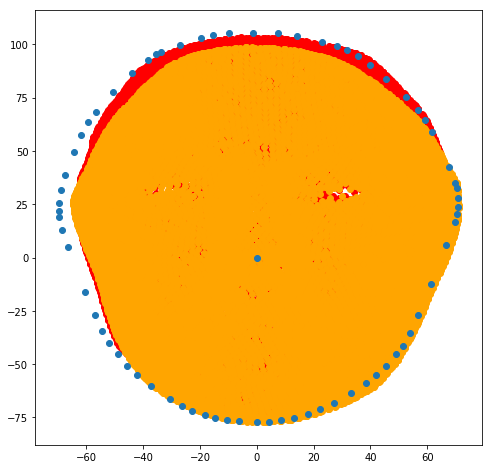

In [10]:
first_face_index = 7
second_face_index = 4
points1 = face_points["face" + str(first_face_index)]
points2 = face_points["face" + str(second_face_index)]
plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], color="red")
plt.scatter(points2[:,0], points2[:,1], color="orange")
plt.scatter(hull[:,0], hull[:,1])
maxind = np.argmax(points1[:,2])
nosex = points1[maxind,0]
nosey = points1[maxind,1]
nosez = points1[maxind,2]
plt.plot(nosex,nosey,"b")
plt.show()

## Delaunay Triangulation 

In [11]:
def triangulation(hull):
    points2D = np.vstack([hull[:,0],hull[:,1]]).T
    tri_hull = Delaunay(points2D) 
    return tri_hull

In [12]:
tri_hull = triangulation(hull)

In [13]:

#tri_hull = triangulation(hull)
ipv.figure()
mesh = ipv.plot_trisurf(hull[:,0], hull[:,1], hull[:,2], triangles=tri_hull.simplices, color='blue')
ipv.scatter(hull[:,0], hull[:,1], hull[:,2], marker='sphere', color='red')
ipv.show()

## Geodesic Patch Extraction

In [14]:
#def get_patch(points, hull, x1, y1, z1):
#    patch_width = 5 * rho
#    def distance(x,y,z,x1,y1,z1,x2,y2,z2):
#        a = (y2-y1)/(x2-x1)
#        b = -1
#        c = y2-x2*(y2-y1)/(x2-x1)
#        return abs(a*x+b*y+c)/(a**2+b**2)**0.5
#
#    patch = []
#    nosex, nosey, nosez = hull[0]
#    for x2,y2,z2 in points:
#        if (y1-nosey)/(y2-nosey+0.0001)>0 and (x1-nosex)/(x2-nosex+0.0001)>0 \
#        and distance(x2,y2,z2,x1,y1,z1,nosex,nosey,nosez)<patch_width:
#            patch.append([x2,y2,z2])
#    patch = np.array(patch)
#    return patch

def get_all_patches_from_face(points, hull, triangles):
    from itertools import combinations
    
    patch_width = 5 * rho
    def distance(x,y,z,x1,y1,z1,x2,y2,z2):
        a = (y2-y1)/(x2-x1)
        b = -1
        c = y2-x2*(y2-y1)/(x2-x1)
        return abs(a*x+b*y+c)/(a**2+b**2)**0.5
    
    patches = []
    for t1,t2 in combinations(triangles,r=2): #pairwise triangles
        if len(set(t1)&set(t2))==2:           #triangles with a common edge
            patch = []
            a_ind, b_ind = list(set(t1)&set(t2))
            x1, y1, z1 = hull[a_ind,:]
            x2, y2, z2 = hull[b_ind,:]
            for x,y,z in points: #loop over all points to find patch points
                if (x-x1/2-x2/2)**2+(y-y1/2-y2/2)**2<(x1/2-x2/2)**2+(y1/2-y2/2)**2 and distance(x,y,z,x1,y1,z1,x2,y2,z2)<patch_width:
                    patch.append([x,y,z])
            if len(patch)==0: 
                #print("ALERT: NO PATCH FOR AN EDGE!!!!")
                pass
            patches.append(np.array(patch))
    return patches


In [15]:
def get_patches(hull, triangles):
    #pdb.set_trace()
    patches = defaultdict(list) # key = edges, values = a list of extracted patches from all faces along that edge 
    for face_index in range(1, len(file_paths)+1):
        all_patches = get_all_patches_from_face(face_points["face"+str(face_index)], hull, triangles)
        #print(len(all_patches))
        # the patches are organised in following way because the original get_patches function was modified after the whole serial code was written
        try:
            for edge_index in range(len(all_patches)):
                patches["edge" + str(edge_index)].append(all_patches[edge_index])
        except:
            pdb.set_trace()
    return patches
#hull= correspondence_set
patches = get_patches(hull, tri_hull.simplices)


In [16]:
# randomly selecting a edge, and plotting all patches along that edge across all the faces
ipv.clear()
edge_index = np.random.choice(range(len(patches)))
edge = patches["edge" + str(edge_index)]
for i in range(len(edge)):
    patch = edge[i]
    ipv.scatter(patch[:,0], patch[:,1], patch[:,2], size=1, marker="sphere", color=["red", "blue", "yellow", "green"][i%4])
ipv.show()

## Keypoint Extraction

In [17]:
# takes in a point and the patch it belongs to and decides whether it is a keypoint (ratio of largest two eigenvalues on the covariance matrix of its local surface) or not
def is_keypoint(point, points):
    threshold = 7 * rho
    nhood = points[(np.sum(np.square(points-point),axis=1)) < threshold**2]
    try:
        nhood = (nhood - np.min(nhood, axis=0)) / (np.max(nhood, axis=0) - np.min(nhood, axis=0))
        covmat = np.cov(nhood)
        eigvals = np.sort(np.abs(np.linalg.eigvalsh(covmat)))
        ratio = eigvals[-1]/(eigvals[-2]+0.0001)
        return ratio>30 #eigen_ratio_threshold #/ 5
    except Exception as e:
        return False


In [18]:
def get_keypoints(patches):
    keypoints = {} # key = edge, value = a list of keypoints extracted from the patches along that edge across all faces
    for edge_index in range(1, len(patches)+1):
        edge_patches = patches["edge" + str(edge_index)]
        edge_keypoints = []
        for patch in edge_patches:
            #print(patch.shape)
            if patch.shape[0]:
                patch_keypoints = patch[np.apply_along_axis(is_keypoint, 1, patch, patch)] # keypoints in `patch`
            else:
                patch_keypoints = []
            edge_keypoints.append(patch_keypoints)
        keypoints["edge" + str(edge_index)] = edge_keypoints 
    return keypoints

keypoints = get_keypoints(patches)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [19]:
# plot keypoints of a face, given the face index
face_index = 1
face_keypoints = []
for edge_index in range(1, len(keypoints)+1):
    try:
        face_keypoints.extend(keypoints["edge" + str(edge_index)][face_index-1])
    except: # not every edge has a patch and hence keypoints, indexing an empty array will give error 
        pass
face_keypoints = np.array(face_keypoints)
print(face_keypoints.shape)
#print(face_keypoints)
points = face_points["face" + str(face_index)]
ipv.clear()
ipv.scatter(points[:,0], points[:,1], points[:,2], size=1, marker="sphere", color="blue")
ipv.scatter(face_keypoints[:, 0], face_keypoints[:,1], face_keypoints[:,2], size=1, marker="sphere", color="red")
ipv.show()

(1435, 3)


## Feature Extraction

In [20]:

def get_normal(x, y, grid_x, grid_y, grid_z):
    '''
      3
    1   2
      4
    x, y are coordinates of the point for which the normal has to be calculated
    '''
    i = (x - grid_x[0, 0]) / (grid_x[1, 0] - grid_x[0, 0])
    j = (y - grid_y[0, 0]) / (grid_y[0, 1] - grid_y[0, 0])
    i,j = int(round(i)), int(round(j))
    if (not 0 <= i < grid_x.shape[0]-1) or (not 0 <= j < grid_y.shape[1]-1):
        warnings.warn("out of bounds error")
        #pdb.set_trace()
        return "None"
    point1 = (grid_x[i-1, j], grid_y[i-1, j], grid_z[i-1, j])
    point2 = (grid_x[i+1, j], grid_y[i+1, j], grid_z[i+1, j])
    point3 = (grid_x[i, j-1], grid_y[i, j-1], grid_z[i, j-1])
    point4 = (grid_x[i, j+1], grid_y[i, j+1], grid_z[i, j+1])
    a1, a2, a3 = [point2[x] - point1[x] for x in range(3)]
    b1, b2, b3 = [point3[x] - point4[x] for x in range(3)]
    normal = np.array([a3*b2, a1*b3, -a1*b2])
    return normal/np.linalg.norm(normal)



In [22]:
# test the get_normal function and plot 
'''If this snippet throws an error, rerun it'''
face_id = 8
grid_x, grid_y, grid_z = grid_data["face" + str(face_id)]
i = np.random.choice(len(grid_x))
j = np.random.choice(len(grid_y))
x, y = grid_x[i, 0], grid_y[0, j]
print(i, j, x, y)
uvn = get_normal(x, y, grid_x, grid_y, grid_z)

ipv.clear()
ipv.plot_mesh(grid_x, grid_y, grid_z, wireframe=False)
ipv.quiver(np.array([x, ]), np.array([y,]), np.array([grid_z[i, j]]), np.array([uvn[0]]), np.array([uvn[1]]), np.array([uvn[2]]), color="blue", size=10)
ipv.show()

124 117 -5.196300000000008 -17.380899999999997


In [ ]:
# moments = cv2.moments(patch2[:, :2])
# central_moments = [moments[key] for key in moments.keys() if key[:2] == "mu"]
# central_moments = np.array(central_moments)
# central_moments

In [23]:
def get_keypoint_features(keypoints, face_index):
    feature_list = [] # a list to store extracted features of each keypoint
    final_keypoints = [] # remove unwanted keypoints, like the ones on edges etc
    for point in keypoints:
        point_features = []
        x, y, z = point
        points = face_points["face" + str(face_index)]
        grid_x, grid_y, grid_z = grid_data["face" + str(face_index)]
        threshold = 5 * rho
        nhood = points[(np.sum(np.square(points-point), axis=1)) < threshold**2]
        xy_hu_moments = cv2.HuMoments(cv2.moments(nhood[:, :2])).flatten()
        yz_hu_moments = cv2.HuMoments(cv2.moments(nhood[:, 1:])).flatten()
        xz_hu_moments = cv2.HuMoments(cv2.moments(nhood[:, ::2])).flatten()
        hu_moments = np.concatenate([xy_hu_moments, yz_hu_moments, xz_hu_moments])
        #print(hu_moments)
        #i = (x - grid_x[0, 0]) / (grid_x[1, 0] - grid_x[0, 0])
        #j = (y - grid_y[0, 0]) / (grid_y[0, 1] - grid_y[0, 0])
        #i, j = int(round(i)), int(round(j))
        #start_i, start_j = i - int(5 * rho / (grid_x[1, 0] - grid_x[0, 0])), j - int(5 * rho / (grid_y[0, 1] - grid_y[0, 0]))
        #end_i, end_j = i + int(5 * rho / (grid_x[1, 0] - grid_x[0, 0])), j + int(5 * rho / (grid_y[0, 1] - grid_y[0, 0]))
        #nhood = points[start_i: end_i, start_j: end_j] 
        #nhood_x = grid_x[start_i:end_i, start_j:end_j]
        #nhood_y = grid_y[start_i:end_i, start_j:end_j]
        #nhood_z = grid_z[start_i:end_i, start_j:end_j]
        normal = get_normal(x, y, grid_x, grid_y, grid_z)
        if normal == "None": # array comparision raises ambiguity error, so None passed as string
            continue
        final_keypoints.append(point)
        point_features.extend(np.array([x, y, z])) # spatial location
        point_features.extend(normal)
        point_features.extend(hu_moments)
        point_features = np.array(point_features)
        
        feature_list.append(point_features)
    final_keypoints = np.array(final_keypoints)
    return final_keypoints, feature_list

In [24]:
def get_features(keypoints):
    features = {} # key = edge + edge_index, value = list of features for each keypoint across all the faces
    for edge_index in range(1, len(keypoints)+1):
        edgewise_keypoint_features = [] # store features of keypoints for a given edge_index across all faces
        for face_index in range(1, len(file_paths)+1):
            try:
                edge_keypoints = keypoints["edge" + str(edge_index)][face_index-1]
                final_keypoints, keypoint_features = get_keypoint_features(edge_keypoints, face_index)
                keypoints["edge" + str(edge_index)][face_index-1] = final_keypoints # update the keypoint, remove unwanted keypoints like those on the edge etc
            except: # for no keypoints, no features
                keypoint_features = []
            edgewise_keypoint_features.append(keypoint_features)
        features["edge" + str(edge_index)] = edgewise_keypoint_features
    return features

features = get_features(keypoints)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: out of bounds error
  del sys.path[0]


## Keypoint matching

In [36]:
def get_keypoint_under_2rho(keypoints, point):
    """return the index of the keypoint in `keypoints` which is closest to `point` if that distance is less than 2 * rho, else return None"""
    try:
        distance = np.sqrt(np.sum(np.square(keypoints-point), axis=1))
        if (distance < 5*rho).any():
            min_dist_index = np.argmin(distance)
            return min_dist_index
    except Exception as e: # keypoints is [], gotta return None
        pass
    return None

def get_matching_keypoints(edge_keypoints, edge_features, edge_index):
    # check if a bunch of keypoints across the patches (across all faces) are withing 2*rho
    # first get all the keypoints in a list
    matching_keypoints_list = []
    for face_index1 in range(len(edge_keypoints)): # take a patch along the edge among the faces
        for point_index, point in enumerate(edge_keypoints[face_index1]): # take a keypoint in that patch, we have to find corresponding keypoints in each other patche along this edge
            matched_keypoint_indices = [] # to store indices of matched keypoints across the patches
            for face_index2 in range(len(edge_keypoints)): # find if matching keypoints exist across the patches along that edge across all faces
                if face_index2 == face_index1: 
                    matched_keypoint_indices.append(point_index)
                    continue
                matched_keypoint = get_keypoint_under_2rho(edge_keypoints[face_index2], point)
                if matched_keypoint:
                    #if edge_index == 36: pdb.set_trace()I#
                    matched_keypoint_indices.append(matched_keypoint)
                else: # no keypoint was matched in the above patch (face_index2), gotta start search on other keypoint from face_index1
                    break
                        
            if len(matched_keypoint_indices) == len(edge_keypoints): # there's a corresponding keypoint for each patch across all faces
                 matching_keypoints_list.append(matched_keypoint_indices)
    if len(matching_keypoints_list) == 0:
        return []
    # now we have those keypoints which are in vicinity of 2*rho, let's compute euclidean distance of their feature vectors
    Kq = 10
    final_matched_keypoints = []
    for matched_keypoints in matching_keypoints_list: # select first list of matching keypoints
        # get the indices, get their corresponding features, compute euclidean distance
        try:
            features = np.array([edge_features[face_index][idx] for face_index, idx in zip(range(len(edge_features)), matched_keypoints)])
            euc_dist_under_kq = lambda feature, features: np.sqrt(np.sum(np.square(features - feature), axis=1)) < Kq
            if np.apply_along_axis(euc_dist_under_kq, 1, features, features).all() == True:
                # we have got a set of matching keypoints, get their mean coordinates
                matched_coords = [edge_keypoints[face_index][idx] for face_index, idx in zip(range(len(edge_features)), matched_keypoints)]
                final_matched_keypoints.append(np.mean(matched_coords, axis=0))
        except:
            pdb.set_trace()
    return final_matched_keypoints



In [37]:
# those keypoints which are in vicinity of 2*rho are considered for matching
# matching is done using constrained nearest neighbour
# choose an edge, select a keypoint, find out keypoints on corresponding patches on other faces within a vicinity of 2*rho, 
# get euclidean distance in features among all possible pair wise combinations, if the distances come out to be less than Kp are added to the global set of correspondences
def keypoint_matching_process(keypoints, features):
    final_mean_keypoints = []
    for edge_index in range(1, len(keypoints)):
        edge_keypoints = keypoints["edge" + str(edge_index)]
        edge_features = features["edge" + str(edge_index)]
        matched_keypoints = get_matching_keypoints(edge_keypoints, edge_features, edge_index)
        if len(matched_keypoints) == 0:
            continue
        #print(matched_keypoints)
        final_mean_keypoints.extend(matched_keypoints)
    #final_mean_keypoints = list(set(final_mean_keypoints))

    final_mean_keypoints = np.array(final_mean_keypoints)
    final_mean_keypoints = np.unique(final_mean_keypoints, axis=0)
    return final_mean_keypoints

final_mean_keypoints = keypoint_matching_process(keypoints, features)
#print("Iteration completed")
#print(len(final_mean_keypoints), "new keypoints found")
print(final_mean_keypoints)

[[-2.16530043e+01 -1.58229750e+01 -3.12710263e+01]
 [-2.14854043e+01 -1.56415500e+01 -3.11643637e+01]
 [-2.13333955e+01 -1.54482000e+01 -3.10634262e+01]
 [-2.12003039e+01 -1.52284750e+01 -3.09789887e+01]
 [-2.00536938e+01 -1.18858375e+01 -3.04073388e+01]
 [-1.93395625e+01  4.26343263e+01 -2.28629012e+01]
 [-1.81898650e+01 -8.45348750e+00 -2.91961637e+01]
 [-1.79109187e+01 -9.90700000e+00 -2.91431013e+01]
 [-1.78797525e+01 -7.58726250e+00 -2.89468013e+01]
 [-1.78037275e+01 -8.21022500e+00 -2.90304887e+01]
 [-1.77955750e+01 -9.22955000e+00 -2.90741012e+01]
 [-1.76387338e+01 -8.04191250e+00 -2.89153887e+01]
 [-1.76078013e+01 -8.30296250e+00 -2.88834137e+01]
 [-1.75533675e+01 -9.61853750e+00 -2.88947513e+01]
 [-1.74826013e+01 -7.86097500e+00 -2.88061887e+01]
 [-1.72924800e+01 -1.34312000e+01 -2.83697388e+01]
 [-1.66123377e+01 -1.45473875e+01 -2.76183137e+01]
 [-1.65503652e+01 -1.39488375e+01 -2.77077012e+01]
 [-1.64830139e+01 -1.34451375e+01 -2.77346263e+01]
 [-1.64560027e+01 -1.43415250e+

In [38]:
updated_hull = np.concatenate((hull, final_mean_keypoints), axis=0)

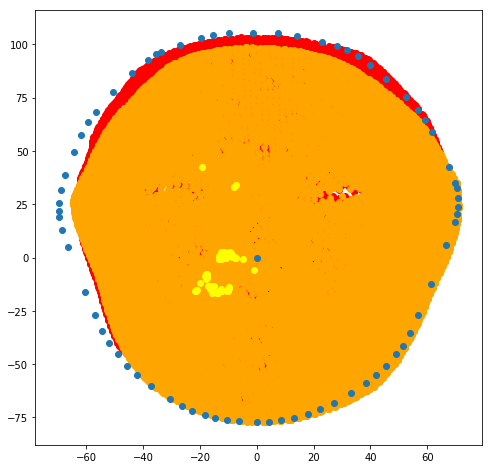

In [39]:
first_face_index = 7
second_face_index = 4
points1 = face_points["face" + str(first_face_index)]
points2 = face_points["face" + str(second_face_index)]
plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], color="red")
plt.scatter(points2[:,0], points2[:,1], color="orange")
#plt.scatter(updated_hull[:,0], updated_hull[:,1])

plt.scatter(hull[:,0], hull[:,1])
plt.scatter(final_mean_keypoints[:, 0], final_mean_keypoints[:, 1], color="yellow")
maxind = np.argmax(points1[:,2])
nosex = points1[maxind,0]
nosey = points1[maxind,1]
nosez = points1[maxind,2]
plt.plot(nosex,nosey,"b")
plt.show()

In [40]:
ipv.clear()
ipv.scatter(points[:,0], points[:,1], points[:,2], size=1, marker="sphere", color="blue")
ipv.scatter(final_mean_keypoints[:, 0], final_mean_keypoints[:,1], final_mean_keypoints[:,2], size=2, marker="sphere", color="red")
ipv.show()

In [41]:
updated_tri_hull = triangulation(updated_hull)
ipv.figure()
mesh = ipv.plot_trisurf(updated_hull[:,0], updated_hull[:,1], updated_hull[:,2], triangles=updated_tri_hull.simplices, color='blue')
ipv.scatter(updated_hull[:,0], updated_hull[:,1], updated_hull[:,2], marker='sphere', color='red')
ipv.show()

In [31]:
updated_patches = get_patches(updated_hull, updated_tri_hull.simplices)

In [42]:
num_iterations = 10
correspondence_set = hull

In [ ]:
# Start correspondence densification loop

for iteration in range(num_iterations):
    print("Starting iteration: ", iteration)
    print("Starting Delaunay triangulation............", end="", flush=True)
    tri_hull = triangulation(correspondence_set)
    print("done")
    print("starting geodesic patch extraction............", end="", flush=True)
    patches = get_patches(correspondence_set, tri_hull.simplices)
    print("Done")
    print("Starting keypoint extraction............", end="", flush=True)
    keypoints = get_keypoints(patches)
    print("Done")
    print("Starting feature extraction............", end="", flush=True)
    features = get_features(keypoints)
    print("Done")
    print("Starting keypoint matching............", end="", flush=True)
    final_mean_keypoints = keypoint_matching_process(keypoints, features)
    print("Done")
    print(final_mean_keypoints)
    print("Total new correspondences found: ", len(final_mean_keypoints))
    correspondence_set = np.concatenate((correspondence_set, final_mean_keypoints), axis=0)
    correspondence_set = np.unique(correspondence_set, axis=0)
    
    #if iteration == 2:
    #    break



Starting iteration:  0
Starting Delaunay triangulation............done
starting geodesic patch extraction............Done
Starting keypoint extraction............

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Done
Starting feature extraction............

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Done
Starting keypoint matching............

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: out of bounds error
  del sys.path[0]


Done
[[-2.25243168e+01  4.47619762e+01 -2.04640512e+01]
 [-2.19045730e+01 -1.60614500e+01 -3.14715513e+01]
 [-2.17535517e+01 -1.58866875e+01 -3.13406013e+01]
 [-2.13008514e+01 -1.52921875e+01 -3.10485637e+01]
 [-2.12449655e+01  4.42699007e+01 -2.09705137e+01]
 [-2.09862262e+01  4.41509632e+01 -2.10835762e+01]
 [-1.99954063e+01 -1.31539125e+01 -3.03775512e+01]
 [-1.99586489e+01 -1.38900000e+01 -3.02537387e+01]
 [-1.98953838e+01 -1.46191125e+01 -3.01168137e+01]
 [-1.98130738e+01 -1.36495375e+01 -3.01760513e+01]
 [-1.97602675e+01 -1.31191125e+01 -3.02540888e+01]
 [-1.97144213e+01 -1.44392500e+01 -3.00288012e+01]
 [-1.96455525e+01 -1.32091125e+01 -3.01491387e+01]
 [-1.96018625e+01 -1.48152625e+01 -2.98901262e+01]
 [-1.93430762e+01 -1.43925500e+01 -2.97163762e+01]
 [-1.91554138e+01 -1.40635875e+01 -2.96736012e+01]
 [-1.89581450e+01 -1.41226750e+01 -2.95063637e+01]
 [-1.87868938e+01 -1.62490250e+01 -2.90071637e+01]
 [-1.87686425e+01 -1.21264750e+01 -2.96081012e+01]
 [-1.86698875e+01 -1.02618

Starting Delaunay triangulation............done
starting geodesic patch extraction............Done
Starting keypoint extraction............Done
Starting feature extraction............Done
Starting keypoint matching............Done
[[-2.34240625e+01  4.48538588e+01 -2.04421637e+01]
 [-2.33504737e+01  4.46874387e+01 -2.06961137e+01]
 [-2.32004013e+01  4.44581262e+01 -2.10149512e+01]
 [-1.67234165e+01 -1.54806750e+01 -2.74555012e+01]
 [-1.56644532e+01 -1.66522125e+01 -2.63863262e+01]
 [-1.56106477e+01 -1.24112375e+01 -2.72587888e+01]
 [-1.51969587e+01 -1.28708000e+01 -2.68257012e+01]
 [-1.46144972e+01 -1.26599375e+01 -2.64522638e+01]
 [-1.44875735e+01 -1.42974500e+01 -2.61355138e+01]
 [-1.42380060e+01 -1.28538125e+01 -2.61376263e+01]
 [-1.41868480e+01 -1.53075250e+01 -2.55434387e+01]
 [-1.40890185e+01 -1.40382000e+01 -2.57897637e+01]
 [-1.40555960e+01 -1.29327000e+01 -2.59552762e+01]
 [-1.39564235e+01 -1.34271375e+01 -2.58194637e+01]
 [-1.37252160e+01 -1.38046125e+01 -2.55227888e+01]
 [-1

In [34]:
len(correspondence_set)
#correspondence_set

115

In [35]:

tri_hull = triangulation(correspondence_set)
print("done")
print("starting geodesic patch extraction............", end="", flush=True)
patches = get_patches(correspondence_set, tri_hull.simplices)


done
starting geodesic patch extraction............

In [ ]:
patches.keys()

In [ ]:
ipv.clear()
face_index = 3
points = face_points["face" + str(face_index)]
ipv.scatter(points[:,0], points[:,1], points[:,2], size=1, marker="sphere", color="blue")
for key in patches.keys():
    patch = patches[key][face_index-1]
    if len(patch):
        ipv.scatter(patch[:, 0], patch[:,1], patch[:,2], size=2, marker="sphere", color="red")
ipv.show()

In [ ]:
updated_hull = correspondence_set
updated_tri_hull = triangulation(updated_hull)
ipv.figure()
mesh = ipv.plot_trisurf(updated_hull[:,0], updated_hull[:,1], updated_hull[:,2], triangles=updated_tri_hull.simplices, color='blue')
ipv.scatter(updated_hull[:,0], updated_hull[:,1], updated_hull[:,2], marker='sphere', color='red')
ipv.show()

In [ ]:
xy_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, :2])).flatten()
yz_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, 1:])).flatten()
xz_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, ::2])).flatten()
hu_moments = np.concatenate([xy_hu_moments, yz_hu_moments, xz_hu_moments])
hu_moments.shape


In [ ]:
def surface_curvature(X,Y,Z):

    (lr,lb)=X.shape


    #First Derivatives
    Xv,Xu=np.gradient(X)
    Yv,Yu=np.gradient(Y)
    Zv,Zu=np.gradient(Z)

    #Second Derivatives
    Xuv,Xuu=np.gradient(Xu)
    Yuv,Yuu=np.gradient(Yu)
    Zuv,Zuu=np.gradient(Zu)   

    Xvv,Xuv=np.gradient(Xv)
    Yvv,Yuv=np.gradient(Yv)
    Zvv,Zuv=np.gradient(Zv) 

    #2D to 1D conversion 
    #Reshape to 1D vectors
    Xu=np.reshape(Xu,lr*lb)
    Yu=np.reshape(Yu,lr*lb)
    Zu=np.reshape(Zu,lr*lb)
    Xv=np.reshape(Xv,lr*lb)
    Yv=np.reshape(Yv,lr*lb)
    Zv=np.reshape(Zv,lr*lb)
    Xuu=np.reshape(Xuu,lr*lb)
    Yuu=np.reshape(Yuu,lr*lb)
    Zuu=np.reshape(Zuu,lr*lb)
    Xuv=np.reshape(Xuv,lr*lb)
    Yuv=np.reshape(Yuv,lr*lb)
    Zuv=np.reshape(Zuv,lr*lb)
    Xvv=np.reshape(Xvv,lr*lb)
    Yvv=np.reshape(Yvv,lr*lb)
    Zvv=np.reshape(Zvv,lr*lb)

    Xu=np.c_[Xu, Yu, Zu]
    Xv=np.c_[Xv, Yv, Zv]
    Xuu=np.c_[Xuu, Yuu, Zuu]
    Xuv=np.c_[Xuv, Yuv, Zuv]
    Xvv=np.c_[Xvv, Yvv, Zvv]

    #% First fundamental Coeffecients of the surface (E,F,G)
    E=np.einsum('ij,ij->i', Xu, Xu) 
    F=np.einsum('ij,ij->i', Xu, Xv) 
    G=np.einsum('ij,ij->i', Xv, Xv) 

    m=np.cross(Xu,Xv,axisa=1, axisb=1) 
    p=np.sqrt(np.einsum('ij,ij->i', m, m)) 
    n=m/np.c_[p,p,p]
    # n is the normal
    #% Second fundamental Coeffecients of the surface (L,M,N), (e,f,g)
    L= np.einsum('ij,ij->i', Xuu, n) #e
    M= np.einsum('ij,ij->i', Xuv, n) #f
    N= np.einsum('ij,ij->i', Xvv, n) #g

    # Alternative formula for gaussian curvature in wiki 
    # K = det(second fundamental) / det(first fundamental)
    #% Gaussian Curvature
    K=(L*N-M**2)/(E*G-L**2)
    K=np.reshape(K,lr*lb)
    #wiki trace of (second fundamental)(first fundamental inverse)
    #% Mean Curvature
    H = (E*N + G*L - 2*F*M)/((E*G - F**2))
    H = np.reshape(H,lr*lb)

    #% Principle Curvatures
    Pmax = H + np.sqrt(H**2 - K)
    Pmin = H - np.sqrt(H**2 - K)
    #[Pmax, Pmin]
    return [Pmax, Pmin, G, H]


def fun(x,y):
    return x**2+y**2

In [ ]:
x1, y1, z1 = patch1[:, 0], patch1[:, 1], patch1[:, 2]

In [ ]:
[pgrid_x,pgrid_y] = scipy.meshgrid(x1, y1)

In [ ]:
plt.scatter(pgrid_x, pgrid_y);
plt.scatter(x1, y1)

In [ ]:
pgrid_z = scipy.interpolate.griddata((patch1[:, 0], patch1[:, 1]), patch1[:, 2], (pgrid_x, pgrid_y), method='cubic')

In [ ]:
ipv.figure()
ipv.plot_surface(pgrid_x, pgrid_z, pgrid_y)
ipv.show()

In [ ]:
k1, k2, G, H = surface_curvature(pgrid_x,pgrid_y,pgrid_z)

In [ ]:
k1, k2, G, H

In [ ]:
for i in range(len(patch1)):
    print(k1[i*i])

In [ ]:
# Shape index

Sa = 1/2 - 1/np.pi * np.arctan((k1+k2)/(k1-k2))
Sb = 2/np.pi * np.arctan((k1+k2)/(k1-k2))

print(Sa)
print(Sb)

In [ ]:
curvedness = np.sqrt((k1**2 + k2**2)/2)
log_curvedness = 2/np.pi * np.log10(curvedness)
willmore_energy = H**2 - G
shape_curvedness = Sb * log_curvedness
log_difference_map = np.log(G - H + 1) 
